# Packages

In [1]:
import pandas as pd
import numpy as np
import os, re, csv, codecs, operator, sys, gc
from collections import defaultdict, OrderedDict
from tqdm import tqdm
import jieba
import seaborn as sns
from collections import Counter
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold, KFold, train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


# Parameters

In [2]:
jieba.set_dictionary('dict.txt.big.txt')
CLEAN_WORD_PATH = None
TRAIN_DATA_FILE = 'data_original.csv'
TEST_DATA_FILE = 'test.csv'
FOLD_COUNT = 10
list_classes = ['不受理', '不成立', '成立', '當事人不到場', '聲請人撤回']

# Data Overview

In [3]:
train_df = pd.read_csv(TRAIN_DATA_FILE)

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6277 entries, 0 to 6276
Data columns (total 22 columns):
Unnamed: 0    6277 non-null int64
id            6277 non-null int64
收件日期          6277 non-null object
收件時間          6277 non-null object
結案日期          6220 non-null object
結案時間          6220 non-null object
協調開會方式        5251 non-null object
案件大類型         6277 non-null object
案件細節類型        6261 non-null object
name          6277 non-null float64
對照人           6271 non-null float64
主席            6251 non-null float64
people        4881 non-null float64
是否成立          6277 non-null object
和解條件          1649 non-null object
調解現況          6277 non-null object
調解次數          6274 non-null float64
調解人數          6277 non-null int64
have_other    6277 non-null int64
調解天數          6277 non-null object
縣市合併          6277 non-null int64
調解內容與決議       5942 non-null object
dtypes: float64(5), int64(5), object(12)
memory usage: 1.1+ MB


In [5]:
train_df.describe()

,Unnamed: 0,id,name,對照人,主席,people,調解次數,調解人數,have_other,縣市合併
count,6277.000000,6.277000e+03,6.277000e+03,6.271000e+03,6.251000e+03,4.881000e+03,6274.000000,6277.000000,6277.000000,6277.000000
mean,3141.780628,1.026955e+07,5.672547e+91,1.469835e+95,3.802502e+14,3.179040e+18,1.464616,3.140354,0.328342,0.837502
std,1817.151939,2.622364e+05,4.493388e+93,6.812509e+96,7.871190e+12,1.059711e+19,0.884592,1.785473,0.469647,0.368936
min,0.000000,9.800147e+06,2.651900e+04,2.957900e+04,3.710000e+14,2.060000e+14,1.000000,1.000000,0.000000,0.000000
25%,1569.000000,1.000072e+07,2.650000e+14,2.650000e+14,3.710000e+14,2.640000e+14,1.000000,2.000000,0.000000,1.000000
50%,3138.000000,1.030058e+07,3.410000e+14,3.420000e+14,3.850000e+14,3.410000e+14,1.000000,3.000000,0.000000,1.000000
75%,4713.000000,1.050046e+07,4.060000e+14,4.060000e+14,3.850000e+14,3.720000e+14,2.000000,4.000000,1.000000,1.000000
max,6293.000000,1.070014e+07,3.560000e+95,3.600000e+98,3.900000e+14,3.850000e+19,24.000000,33.000000,1.000000,1.000000


In [6]:
train_df.corr()

,Unnamed: 0,id,name,對照人,主席,people,調解次數,調解人數,have_other,縣市合併
Unnamed: 0,1.000000,0.984876,0.011837,-0.001737,-0.911305,-0.057375,-0.084035,-0.029792,0.032234,0.637676
id,0.984876,1.000000,0.011121,-0.002281,-0.884550,-0.057837,-0.078738,-0.021440,0.030596,0.688910
name,0.011837,0.011121,0.000000,-0.000000,-0.014866,0.047717,0.007641,-0.000990,-0.008822,0.005557
對照人,-0.001737,-0.002281,-0.000000,0.000000,0.003506,-0.005959,0.010095,0.094115,0.030664,0.009510
主席,-0.911305,-0.884550,-0.014866,0.003506,1.000000,0.051441,0.075239,0.044996,-0.026098,-0.543665
people,-0.057375,-0.057837,0.047717,-0.005959,0.051441,1.000000,0.010421,-0.020318,-0.016632,-0.051110
調解次數,-0.084035,-0.078738,0.007641,0.010095,0.075239,0.010421,1.000000,0.115864,0.104137,-0.030812
調解人數,-0.029792,-0.021440,-0.000990,0.094115,0.044996,-0.020318,0.115864,1.000000,0.573040,0.070428
have_other,0.032234,0.030596,-0.008822,0.030664,-0.026098,-0.016632,0.104137,0.573040,1.000000,0.042217
縣市合併,0.637676,0.688910,0.005557,0.009510,-0.543665,-0.051110,-0.030812,0.070428,0.042217,1.000000


In [7]:
train_df.head(10)

,Unnamed: 0,id,收件日期,收件時間,結案日期,結案時間,協調開會方式,案件大類型,案件細節類型,name,...,people,是否成立,和解條件,調解現況,調解次數,調解人數,have_other,調解天數,縣市合併,調解內容與決議
0,0,9800147,2009/3/19,10:48,2009/3/19,15:00,獨任,A.民事,損害賠償,3.560000e+14,...,3.230000e+14,當事人不到場,NaN,調解書已歸檔。,1.0,3,0,1,0,民國〈下同〉97年12月6日下午6時30分許，OOO駕駛皇冠交通股份有限公司所有（車號：99...
1,1,9800150,2009/3/19,19:49,2009/5/5,14:30,獨任,B.刑事,車禍傷害糾紛,2.680000e+21,...,3.850000e+14,成立,NaN,調解書已歸檔。,2.0,5,1,34,0,民國〈下同〉98年2月7日0時5分許，第3人XXX騎乘本人CE7－063號機車搭載梁信瑋與陳...
2,2,9800151,2009/3/23,08:50,2009/4/14,15:30,NaN,A.民事,車禍損害賠償,2.780000e+14,...,NaN,當事人不到場,NaN,調解書已歸檔。,2.0,3,0,17,0,民國〈下同〉98年1月25日19時45分許，汪國全騎乘本人所有981－CBS號機車，在臺南市...
3,3,9800152,2009/3/23,08:55,2009/3/31,15:00,獨任,B.刑事,車禍傷害糾紛,3.410000e+14,...,3.040000e+14,聲請人撤回,NaN,調解書已歸檔。,1.0,3,0,7,0,民國〈下同〉98年2月12日9時49分許，謝天智駕駛OOO所有N8－0250號自小客車，在臺...
4,4,9800153,2009/3/23,08:59,2009/4/16,15:00,NaN,A.民事,財務糾紛,2.960000e+14,...,NaN,當事人不到場,NaN,調解書已歸檔。,2.0,2,0,19,0,雙方因合夥投資，辦理企業貸款及退股爭議申請調解，經調解結果如下：
5,5,9800154,2009/3/19,09:32,2009/4/28,14:30,NaN,B.刑事,車禍傷害糾紛,3.040000e+14,...,NaN,聲請人撤回,NaN,調解書已歸檔。,2.0,3,0,29,0,民國〈下同〉98年3月4日21時15分許，聲請人OOO騎乘本人所有TLM－290號機車搭載王...
6,6,9800157,2009/3/27,14:34,2009/6/9,14:00,獨任,B.刑事,車禍傷害糾紛,2.160000e+14,...,3.850000e+14,成立,NaN,調解書已歸檔。,6.0,3,1,53,0,民國〈下同〉97年12月18日9時55分許，OOO騎乘（車號：NM2－716號）機車與XXX...
7,7,9800158,2009/3/27,15:41,2009/4/2,14:30,獨任,A.民事,債務糾紛,4.060000e+14,...,3.230000e+14,當事人不到場,NaN,調解書已歸檔。,1.0,2,0,5,0,聲請人指稱XXX93年間，向聲請人借款新台幣壹拾貳萬捌佰元，經臺灣臺南地方法院94年9月7日...
8,8,9800159,2009/3/27,16:17,2009/5/21,15:00,獨任,B.刑事,毀損糾紛,3.560000e+14,...,3.230000e+14,不成立,NaN,調解書已歸檔。,2.0,3,0,40,0,OOO指稱98年1月21日19時在台南市開元路73巷66之7號其所有之電動車損壞，與王俊能、...
9,9,9800160,2009/3/27,16:40,2009/4/2,15:00,NaN,A.民事,損害賠償,2.650000e+14,...,NaN,聲請人撤回,NaN,調解書已歸檔。,1.0,2,0,5,0,NaN


In [8]:
print(np.any(train_df.isnull()) == True)

True


In [9]:
train_comments = train_df['調解內容與決議'].fillna('no comment').values
train_comments_lengths = [len(str(s)) for s in train_comments]

In [10]:
def explore_comments(arr):
    print("MAX LENGTH:\t\t", np.max(arr))
    print("AVG LENGTH:\t\t", np.average(arr))
    print("MIN LENGTH:\t\t", np.min(arr))
    print("STANDARD DIVISION:\t", np.std(arr))
    print("RANGE:\t\t\t", np.min(arr), " to ", np.average(arr) + 2 * np.std(arr))
    
print("------Train------")
explore_comments(train_comments_lengths)

------Train------
MAX LENGTH:		 1041
AVG LENGTH:		 207.80277202485263
MIN LENGTH:		 5
STANDARD DIVISION:	 114.29728909040288
RANGE:			 5  to  436.3973502056584


In [11]:
print(train_df['是否成立'].value_counts())

成立        3580
不成立       1497
當事人不到場     832
聲請人撤回      347
不受理         21
Name: 是否成立, dtype: int64


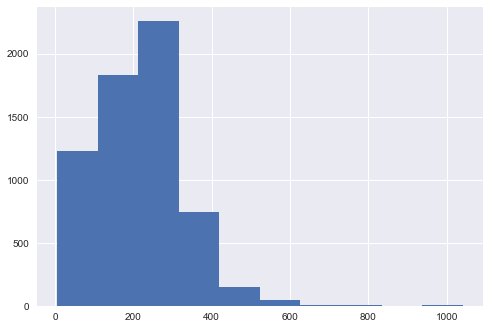

In [12]:
sns.set()
pd.Series(train_comments_lengths).astype(int).hist()
plt.show()

# Data Cleaning

## Transfer Lable to One-hot

In [13]:
Score = train_df['是否成立']
data = pd.get_dummies(Score)
train_df = pd.concat([train_df, data], axis=1)
train_df.head()

,Unnamed: 0,id,收件日期,收件時間,結案日期,結案時間,協調開會方式,案件大類型,案件細節類型,name,...,調解人數,have_other,調解天數,縣市合併,調解內容與決議,不受理,不成立,成立,當事人不到場,聲請人撤回
0,0,9800147,2009/3/19,10:48,2009/3/19,15:00,獨任,A.民事,損害賠償,3.560000e+14,...,3,0,1,0,民國〈下同〉97年12月6日下午6時30分許，OOO駕駛皇冠交通股份有限公司所有（車號：99...,0,0,0,1,0
1,1,9800150,2009/3/19,19:49,2009/5/5,14:30,獨任,B.刑事,車禍傷害糾紛,2.680000e+21,...,5,1,34,0,民國〈下同〉98年2月7日0時5分許，第3人XXX騎乘本人CE7－063號機車搭載梁信瑋與陳...,0,0,1,0,0
2,2,9800151,2009/3/23,08:50,2009/4/14,15:30,NaN,A.民事,車禍損害賠償,2.780000e+14,...,3,0,17,0,民國〈下同〉98年1月25日19時45分許，汪國全騎乘本人所有981－CBS號機車，在臺南市...,0,0,0,1,0
3,3,9800152,2009/3/23,08:55,2009/3/31,15:00,獨任,B.刑事,車禍傷害糾紛,3.410000e+14,...,3,0,7,0,民國〈下同〉98年2月12日9時49分許，謝天智駕駛OOO所有N8－0250號自小客車，在臺...,0,0,0,0,1
4,4,9800153,2009/3/23,08:59,2009/4/16,15:00,NaN,A.民事,財務糾紛,2.960000e+14,...,2,0,19,0,雙方因合夥投資，辦理企業貸款及退股爭議申請調解，經調解結果如下：,0,0,0,1,0


In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6277 entries, 0 to 6276
Data columns (total 27 columns):
Unnamed: 0    6277 non-null int64
id            6277 non-null int64
收件日期          6277 non-null object
收件時間          6277 non-null object
結案日期          6220 non-null object
結案時間          6220 non-null object
協調開會方式        5251 non-null object
案件大類型         6277 non-null object
案件細節類型        6261 non-null object
name          6277 non-null float64
對照人           6271 non-null float64
主席            6251 non-null float64
people        4881 non-null float64
是否成立          6277 non-null object
和解條件          1649 non-null object
調解現況          6277 non-null object
調解次數          6274 non-null float64
調解人數          6277 non-null int64
have_other    6277 non-null int64
調解天數          6277 non-null object
縣市合併          6277 non-null int64
調解內容與決議       5942 non-null object
不受理           6277 non-null uint8
不成立           6277 non-null uint8
成立            6277 non-null uint8
當事人不到場        6277 no

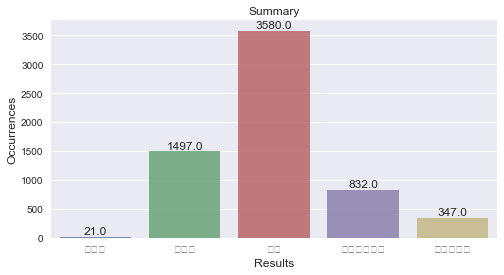

In [15]:
x = train_df.iloc[:, 22:].sum()

plt.figure(figsize=(8, 4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Summary")
plt.ylabel('Occurrences', fontsize=12)
plt.xlabel('Results', fontsize=12)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, ha='center', va='bottom', s='{:.1f}'.format(abs(label)))
    
plt.show()

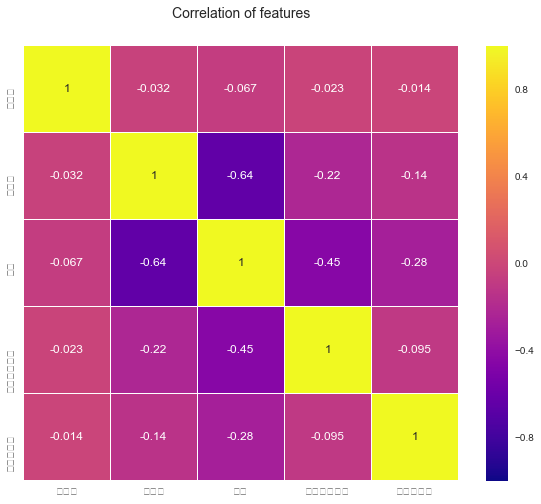

In [16]:
colormap = plt.cm.plasma
plt.figure(figsize=(10, 8))
plt.title('Correlation of features', y=1.05, size=14)
sns.heatmap(data.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

## Processing Clearning

In [17]:
def clean_text(text, remove_stopwords=False):
    # remove url
    text = re.sub(r"(https?:\/\/)*(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)", "", text)
    
    # Special expressions
    text = re.sub(r'〈下同〉', '', text)
    text = re.sub(r'（車號：[a-zA-Z0-9－]*號）', '', text)
    text = re.sub(r'（[\' \']*）', '', text)
    text = re.sub(r'（下同）', '', text)
    text = re.sub(r'\\r\\n[0-9a-zA-Z\\r\\n]*', '', text)
    text = re.sub(r'(口)', '', text)
    
    text = re.sub(r',', '，', text)
    text = re.sub(r'\.+', '...', text)
    text = re.sub(r'\.{6}', '...', text)
    text = re.sub(r'…', '...', text)
    text = re.sub(r';', '；', text)
    text = re.sub(r'°', '。', text)
    text = re.sub(r'】', ']', text)
    text = re.sub(r'【', '[', text)
    text = re.sub(r'\)', '\）', text)
    text = re.sub(r'\(', '\（', text)
    text = re.sub(r'“', '"', text)
    text = re.sub(r' ', '', text)
    text = re.sub(r'”', '"', text)
    text = re.sub(r'～', '~', text)
    text = re.sub(r'·', '。', text)
    text = re.sub(r'!', '！', text)
    text = re.sub(r'—', '-', text)
    text = re.sub(r'》', '\）', text)
    text = re.sub(r'《', '\（', text)
    text = re.sub(r'\?', '\？', text)
    text = re.sub(r'。。。', '...', text)
    text = re.sub(r'。。。。。。', '...', text)
    text = re.sub(r':', '：', text)
    
    text = special_alpha_removal.sub('', text)
    
    return text

# regex to remove all Non-Alpha Numeric and space
special_character_removal = re.compile(r'[^a-z\d ]', re.IGNORECASE)

# regex to remove all Alpha Numeric and space
special_alpha_removal = re.compile(r'[a-z\d ]', re.IGNORECASE)

# regex to replace all numeric
replace_numbers = re.compile(r'\d+', re.IGNORECASE)

# regex to replace ###...
replace_sharp = re.compile(r'[#]+', re.IGNORECASE)

In [18]:
cleaned_train_comments = []
print('Processing data cleaning...')

for text in train_comments:
    cleaned_train_comments.append(clean_text(text))
    
train_df['cleaned_comments'] = cleaned_train_comments
print('Done!')

Processing data cleaning...
Done!


## Word segmentation analysis

In [19]:
word_dict = defaultdict(int)

for sentence in tqdm(train_df['調解內容與決議']):
    seg_list = jieba.cut(str(sentence), cut_all=False)
    for word in seg_list:
        word_dict[word] += 1
word_dict = sorted(word_dict.items(), key=operator.itemgetter(1), reverse=True)
print(len(word_dict))

  0%|                                                                                         | 0/6277 [00:00<?, ?it/s]Building prefix dict from C:\Users\CZJ\Desktop\dict.txt.big.txt ...
Loading model from cache C:\Users\CZJ\AppData\Local\Temp\jieba.u28d6904473ddf2ff282219392fdef7a7.cache
Loading model cost 1.371 seconds.
Prefix dict has been built succesfully.
100%|█████████████████████████████████████████████████████████████████████████████| 6277/6277 [00:09<00:00, 630.83it/s]


25386


In [25]:
cleaned_word_dict = defaultdict(int)

for sentence in tqdm(train_df['cleaned_comments']):
    seg_list = jieba.cut(str(sentence), cut_all=False)
    for word in seg_list:
        cleaned_word_dict[word] += 1
cleaned_word_dict = sorted(cleaned_word_dict.items(), key=operator.itemgetter(1), reverse=True)
print(len(cleaned_word_dict))

100%|█████████████████████████████████████████████████████████████████████████████| 6277/6277 [00:06<00:00, 948.96it/s]


17196


In [26]:
cut_sentences = []
for sentence in tqdm(train_df['cleaned_comments']):
    seg_list = jieba.cut(str(sentence), cut_all=False)
    cut_sentences.append(" ".join(seg_list))
train_df['cleaned_comments_cut'] = cut_sentences

100%|█████████████████████████████████████████████████████████████████████████████| 6277/6277 [00:06<00:00, 976.03it/s]


In [30]:
cut_train_sentences = train_df['cleaned_comments_cut']

## A quick view of vocabulary

In [28]:
chinese_list, sign_list, dig_english_list = [], [], []
for word, count in word_dict:
    for char in word:
        if char >= u'\u4E00' and char <= u"\u9FA5":
            chinese_list.append((word, count))
        elif (char >= u'\u0041' and char <= u'\u005A') or (char >= u'\u0061' and char <= u'\u007A') or (char >= u'\u0030' and char <= u'\u0039'):
            dig_english_list.append((word, count))
            break
        else:
            sign_list.append((word, count))
            break
sorted_dig_english_list = sorted(set(dig_english_list), key=lambda x: x[1], reverse=True)
sorted_sign_list = sorted(set(sign_list), key=lambda x: x[1], reverse=True)
sorted_chinese_list = sorted(set(chinese_list), key=lambda x: x[1], reverse=True)
print("chinese_word: ", len(sorted_chinese_list))
print("dig_english_word: ", len(sorted_dig_english_list))
print("sign_count: ", len(sorted_sign_list))
print(sorted_chinese_list[:10000], '\n\n', sorted_dig_english_list[:50], '\n\n', sorted_sign_list[:20])

chinese_word:  16892
dig_english_word:  8422
sign_count:  72
[('人', 16399), ('年', 10262), ('月', 10200), ('日', 8569), ('聲請', 8521), ('給付', 7559), ('對造', 7204), ('與', 6799), ('下同', 6500), ('同意', 6220), ('結果', 5878), ('如下', 5743), ('不', 5593), ('民國', 5307), ('解', 5175), ('請調', 5173), ('騎乘', 5158), ('號', 5154), ('調解', 5025), ('故聲', 5008), ('機車', 4939), ('在', 4602), ('時', 4590), ('車損', 4486), ('新台幣', 4466), ('臺南市', 4432), ('發生', 4338), ('含', 4126), ('車禍', 4118), ('兩造', 4052), ('北區', 3946), ('本', 3866), ('其餘', 3822), ('汽車', 3729), ('強制', 3696), ('一', 3675), ('責任保險', 3617), ('事件', 3609), ('二', 3572), ('共計', 3556), ('拋棄', 3539), ('民事', 3538), ('請求權', 3536), ('造人', 3460), ('費用', 3401), ('萬元', 3398), ('駕駛', 3337), ('對', 3283), ('請', 3268), ('他', 3086), ('及其', 3074), ('必要', 3058), ('一切', 3047), ('所有', 2988), ('經', 2850), ('三', 2840), ('慰問金', 2792), ('體傷', 2774), ('醫療費', 2764), ('重型', 2747), ('分許', 2719), ('之', 2573), ('追究', 2536), ('刑事責任', 2530), ('付清', 2456), ('路', 2388), ('整', 2181), ('車費', 205

In [29]:
chinese_list, sign_list, dig_english_list = [], [], []
for word, count in cleaned_word_dict:
    for char in word:
        if char >= u'\u4E00' and char <= u"\u9FA5":
            chinese_list.append((word, count))
        elif (char >= u'\u0041' and char <= u'\u005A') or (char >= u'\u0061' and char <= u'\u007A') or (char >= u'\u0030' and char <= u'\u0039'):
            dig_english_list.append((word, count))
            break
        else:
            sign_list.append((word, count))
            break
sorted_dig_english_list = sorted(set(dig_english_list), key=lambda x: x[1], reverse=True)
sorted_sign_list = sorted(set(sign_list), key=lambda x: x[1], reverse=True)
sorted_chinese_list = sorted(set(chinese_list), key=lambda x: x[1], reverse=True)
print("chinese_word: ", len(sorted_chinese_list))
print("dig_english_word: ", len(sorted_dig_english_list))
print("sign_count: ", len(sorted_sign_list))
print(sorted_chinese_list[:10000], '\n\n', sorted_dig_english_list[:50], '\n\n', sorted_sign_list[:20])

chinese_word:  17142
dig_english_word:  0
sign_count:  54
[('人', 14891), ('聲請', 8549), ('給付', 7556), ('對造', 7234), ('與', 6771), ('同意', 6220), ('結果', 5878), ('如下', 5743), ('不', 5617), ('年月日', 5336), ('民國', 5305), ('解', 5175), ('請調', 5173), ('騎乘', 5157), ('調解', 5025), ('故聲', 5009), ('機車', 4938), ('在', 4655), ('年月日時', 4443), ('車損', 4441), ('臺南市', 4432), ('新台幣', 4355), ('發生', 4340), ('含', 4144), ('車禍', 4118), ('兩造', 4052), ('北區', 3946), ('本', 3868), ('其餘', 3822), ('號', 3736), ('汽車', 3730), ('強制', 3696), ('責任保險', 3617), ('事件', 3609), ('一', 3602), ('二', 3571), ('共計', 3556), ('拋棄', 3539), ('民事', 3538), ('請求權', 3536), ('萬元', 3446), ('費用', 3401), ('造人', 3344), ('駕駛', 3338), ('對', 3250), ('請', 3231), ('他', 3086), ('及其', 3074), ('必要', 3058), ('一切', 3047), ('所有', 2988), ('經', 2840), ('三', 2813), ('慰問金', 2792), ('醫療費', 2764), ('重型', 2747), ('分許', 2662), ('追究', 2535), ('刑事責任', 2530), ('之', 2524), ('付清', 2457), ('體傷', 2337), ('整', 2184), ('車費', 2053), ('雙方', 2040), ('自小', 1942), ('於', 1865), ('路', 18

# Build Vocabulary

In [31]:
tokenizer = Tokenizer(num_words=20000, filters='"#$%&()+,-./:;<=>@[\\]^_`{|}~\t\n')

In [32]:
print('Automatically train vocab & tokenizer...')
tokenizer.fit_on_texts(cut_train_sentences)

train_sequences = tokenizer.texts_to_sequences(cut_train_sentences)

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Automatically train vocab & tokenizer...
Found 17180 unique tokens


# Tf-idf Feature Extraction

## Word-Level

In [33]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 6),
    max_features=20000
)
word_vectorizer.fit(cut_train_sentences)
train_word_features = word_vectorizer.transform(cut_train_sentences)
print('Word vectorization process Done!')

D:\Python\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Word vectorization process Done!


In [34]:
train_tfidf_features = train_word_features.tocsr()

In [35]:
train_tfidf_features.shape

(6277, 20000)

## Temporary Veiw & Processing Col Features

In [36]:
cols = list(train_df.columns)

In [37]:
data_columns = np.array([cols[3]] + cols[5:13] + cols[14:21])
label_column = np.array([cols[13]])

In [38]:
train_df['結案時間'] = [replace_sharp.sub('99:99', str(text)) for text in train_df['結案時間'].fillna(' ').values]
train_df['收件時間'] = [replace_sharp.sub('99:99', str(text)) for text in train_df['收件時間'].fillna(' ').values]

In [39]:
new_col = []
for lin in train_df['對照人'].fillna(' ').values:
    temp = "000000"
    if temp in str(lin):
        new_col.append(lin)
    else:
        new_col.append("gb")

print(len(new_col))

6277


In [40]:
feature_data = []
for column in data_columns:
    try:
        le = LabelEncoder()
        le.fit(list(train_df[column].fillna(' ').values))
        feature_data.append(le.transform(list(train_df[column].fillna(' ').values)))
    except:
        print(column)
feature_data

[array([192, 616,  74, ...,  73,  79,  88], dtype=int64),
 array([46, 42, 50, ..., 13, 37, 37], dtype=int64),
 array([2, 2, 0, ..., 2, 2, 2], dtype=int64),
 array([0, 1, 0, ..., 1, 0, 1], dtype=int64),
 array([128, 224, 226, ..., 224, 128, 224], dtype=int64),
 array([182, 304, 142, ..., 133, 192, 182], dtype=int64),
 array([275, 645, 156, ..., 259, 327, 159], dtype=int64),
 array([3, 3, 3, ..., 1, 1, 1], dtype=int64),
 array([13, 18,  0, ...,  5,  0, 14], dtype=int64),
 array([   0,    0,    0, ...,   47, 1176,  532], dtype=int64),
 array([4, 4, 4, ..., 5, 5, 5], dtype=int64),
 array([1, 4, 4, ..., 1, 1, 1], dtype=int64),
 array([2, 4, 2, ..., 1, 1, 2], dtype=int64),
 array([0, 1, 0, ..., 0, 0, 0], dtype=int64),
 array([ 69, 200, 133, ...,  70,  70,  70], dtype=int64),
 array([0, 0, 0, ..., 1, 1, 1], dtype=int64)]

In [41]:
train_feature_sets = []
for line in zip(feature_data[0], feature_data[0], feature_data[1], feature_data[2], feature_data[3], feature_data[4], feature_data[5], 
                feature_data[6], feature_data[7], feature_data[8], feature_data[9], feature_data[10], feature_data[11], feature_data[12],
                feature_data[13], feature_data[14], feature_data[15]):
    train_feature_sets.append(line)
train_feature_sets = np.array(train_feature_sets)

# Model Training

## Logistic Regression Model with Tfidf Features (Multi-Lables)

In [42]:
kfold = KFold(n_splits=FOLD_COUNT, shuffle=False)
tfidf_models = []
for i, (train_idx, test_idx) in enumerate(kfold.split(train_tfidf_features)):
    print('## In fold {} ##'.format(i + 1))
    classifier = LogisticRegression(solver='sag', C=12.0)
    
    for class_name in list_classes:
        print('Processing {} ...'.format(class_name))
        train_target = train_df[class_name][train_idx]
        
        classifier.fit(train_tfidf_features[train_idx], train_target)
        y_pred = classifier.predict(train_tfidf_features[train_idx])
        
        print('Training accuracy is {}'.format(accuracy_score(y_pred, train_target)))
        
        val_target = train_df[class_name][test_idx]
        val_pred = classifier.predict(train_tfidf_features[test_idx])
        
        print('Validation accuracy is {}'.format(accuracy_score(val_pred, val_target)))
        
    tfidf_models.append(classifier)
print('K-fold cross validation Done!')

## In fold 1 ##
Processing 不受理 ...
Training accuracy is 0.9968135953266065
Validation accuracy is 0.9984076433121019
Processing 不成立 ...
Training accuracy is 0.9697291556027615
Validation accuracy is 0.7579617834394905
Processing 成立 ...
Training accuracy is 0.9835369091874668
Validation accuracy is 0.8726114649681529
Processing 當事人不到場 ...
Training accuracy is 0.96831297574792
Validation accuracy is 0.8487261146496815
Processing 聲請人撤回 ...
Training accuracy is 0.9614090989555674
Validation accuracy is 0.9554140127388535
## In fold 2 ##
Processing 不受理 ...
Training accuracy is 0.9969906178084617
Validation accuracy is 0.9936305732484076
Processing 不成立 ...
Training accuracy is 0.9631793237741193
Validation accuracy is 0.8168789808917197
Processing 成立 ...
Training accuracy is 0.9713223579394583
Validation accuracy is 0.9872611464968153
Processing 當事人不到場 ...
Training accuracy is 0.9658346610019473
Validation accuracy is 0.8535031847133758
Processing 聲請人撤回 ...
Training accuracy is 0.96194016640

In [43]:
for i, (train_idx, test_idx) in enumerate(kfold.split(train_feature_sets)):
    print('## In fold {} ##'.format(i + 1))
    classifier = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, 
                   max_iter=100, multi_class='ovr', penalty='l2', random_state=None, solver='liblinear', tol=0.0001,verbose=0)
    
    for class_name in list_classes:
        print('Processing {} ...'.format(class_name))
        train_target = train_df[class_name][train_idx]
        
        classifier.fit(train_feature_sets[train_idx], train_target)
        y_pred = classifier.predict(train_feature_sets[train_idx])
        
        print('Training accuracy is {}'.format(accuracy_score(y_pred, train_target)))
        
        val_target = train_df[class_name][test_idx]
        val_pred = classifier.predict(train_feature_sets[test_idx])
        
        print('Validation accuracy is {}'.format(accuracy_score(val_pred, val_target)))
        
    tfidf_models.append(classifier)
print('K-fold cross validation Done!')

## In fold 1 ##
Processing 不受理 ...
Training accuracy is 0.9964595503628961
Validation accuracy is 0.9984076433121019
Processing 不成立 ...
Training accuracy is 0.7696937511063905
Validation accuracy is 0.7197452229299363
Processing 成立 ...
Training accuracy is 0.8334218445742609
Validation accuracy is 0.643312101910828
Processing 當事人不到場 ...
Training accuracy is 0.8702425208001416
Validation accuracy is 0.856687898089172
Processing 聲請人撤回 ...
Training accuracy is 0.9433528058063374
Validation accuracy is 0.9570063694267515
## In fold 2 ##
Processing 不受理 ...
Training accuracy is 0.9969906178084617
Validation accuracy is 0.9936305732484076
Processing 不成立 ...
Training accuracy is 0.7663303239511418
Validation accuracy is 0.7388535031847133
Processing 成立 ...
Training accuracy is 0.8445742609311383
Validation accuracy is 0.6242038216560509
Processing 當事人不到場 ...
Training accuracy is 0.8727208355461143
Validation accuracy is 0.8439490445859873
Processing 聲請人撤回 ...
Training accuracy is 0.94494600814

## Multi-Classification

In [45]:
train_label = train_df['是否成立']

In [48]:
kfold = StratifiedKFold(n_splits=FOLD_COUNT, shuffle=False)
multi_classifier_tfidf_models = []
for i, (train_idx, test_idx) in enumerate(kfold.split(train_tfidf_features, train_label)):
    print('## In fold {} ##'.format(i + 1))
    classifier = LogisticRegression(solver='sag', C=12.0)
    
    train_target = train_label[train_idx]
    classifier.fit(train_tfidf_features[train_idx], train_target)
    y_pred = classifier.predict(train_tfidf_features[train_idx])

    print('Training accuracy is {}'.format(accuracy_score(y_pred, train_target)))

    val_target = train_label[test_idx]
    val_pred = classifier.predict(train_tfidf_features[test_idx])

    print('Validation accuracy is {}'.format(accuracy_score(val_pred, val_target)))
        
    multi_classifier_tfidf_models.append(classifier)
print('K-fold cross validation Done!')

## In fold 1 ##
Training accuracy is 0.944572339295201
Validation accuracy is 0.6349206349206349
## In fold 2 ##
Training accuracy is 0.9236898016997167
Validation accuracy is 0.7901430842607313
## In fold 3 ##
Training accuracy is 0.924057355284121
Validation accuracy is 0.7977707006369427
## In fold 4 ##
Training accuracy is 0.9279518498849354
Validation accuracy is 0.7929936305732485
## In fold 5 ##
Training accuracy is 0.9226411754292795
Validation accuracy is 0.7388535031847133
## In fold 6 ##
Training accuracy is 0.9229952203929899
Validation accuracy is 0.7388535031847133
## In fold 7 ##
Training accuracy is 0.9244114002478315
Validation accuracy is 0.7738853503184714
## In fold 8 ##
Training accuracy is 0.9256768713502035
Validation accuracy is 0.7811501597444089
## In fold 9 ##
Training accuracy is 0.9292160679525747
Validation accuracy is 0.7332268370607029
## In fold 10 ##
Training accuracy is 0.9247920721996107
Validation accuracy is 0.7827476038338658
K-fold cross validati

In [49]:
for i, (train_idx, test_idx) in enumerate(kfold.split(train_feature_sets, train_label)):
    print('## In fold {} ##'.format(i + 1))
    classifier = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, 
                   max_iter=100, multi_class='ovr', penalty='l2', random_state=None, solver='liblinear', tol=0.0001,verbose=0)
    train_target = train_label[train_idx]

    classifier.fit(train_feature_sets[train_idx], train_target)
    y_pred = classifier.predict(train_feature_sets[train_idx])

    print('Training accuracy is {}'.format(accuracy_score(y_pred, train_target)))

    val_target = train_label[test_idx]
    val_pred = classifier.predict(train_feature_sets[test_idx])

    print('Validation accuracy is {}'.format(accuracy_score(val_pred, val_target)))
        
    multi_classifier_tfidf_models.append(classifier)
print('K-fold cross validation Done!')

## In fold 1 ##
Training accuracy is 0.6966530901363556
Validation accuracy is 0.5825396825396826
## In fold 2 ##
Training accuracy is 0.6921033994334278
Validation accuracy is 0.5977742448330684
## In fold 3 ##
Training accuracy is 0.6999468932554435
Validation accuracy is 0.589171974522293
## In fold 4 ##
Training accuracy is 0.6925119490175252
Validation accuracy is 0.5971337579617835
## In fold 5 ##
Training accuracy is 0.6910957691626837
Validation accuracy is 0.6401273885350318
## In fold 6 ##
Training accuracy is 0.6818906001062135
Validation accuracy is 0.7436305732484076
## In fold 7 ##
Training accuracy is 0.6756948132412817
Validation accuracy is 0.7786624203821656
## In fold 8 ##
Training accuracy is 0.6745708724119625
Validation accuracy is 0.7811501597444089
## In fold 9 ##
Training accuracy is 0.6789948681649266
Validation accuracy is 0.6869009584664537
## In fold 10 ##
Training accuracy is 0.6751017519023181
Validation accuracy is 0.6693290734824281
K-fold cross validat

# ExtraTreesClassifier

In [ ]:
accs = []
et_predictions = OrderedDict()
et_predictions['id'] = test_df['id']

for class_name in list_classes:
    train_target = train_df[class_name]
    classifier = ExtraTreesClassifier(n_estimators=30)
    
    cv_score = np.mean(cross_val_score(classifier, train_tfidf_features, train_target, cv=10, scoring='roc_auc'))
    accs.append(cv_score)
    print('CV Score for class {} is {}'.format(class_name, cv_score))
    
    classifier.fit(train_tfidf_features, train_target)
    et_predictions[class_name] = classifier.predict_proba(test_tfidf_features)[:, 1]
    
submission = pd.DataFrame.from_dict(et_predictions)
submission.to_csv('result/LR_Based/ExtraTreesClassifier_Submission.csv', index=False)

# Predictions (Optional)

In [ ]:
for i, model in enumerate(tfidf_models):
    print('## In Model {} ##'.format(i + 1))
    predictions = OrderedDict()
    predictions['id'] = test_df['id']
    
    for class_name in list_classes:
        predictions[class_name] = model.predict_proba(test_tfidf_features)[:, 1]
        print('Predict the proba for {} Done!'.format(class_name))
        print(predictions.keys())
    
    print(predictions.keys())
    submission = pd.DataFrame.from_dict(predictions)
    submission.to_csv('Logistic_Regression_Submission_{}.csv'.format(i), index=False)

# Result Ensemble

In [ ]:
def bagging(arrs, path):
    print("Doing ensemble on")
    subs = []
    for arr in arrs:
        print(arr)
        subs.append(pd.read_csv(arr))
    
    for sub in subs[1:]:
        for c in list_classes:
            subs[0][c] += sub[c]
    
    for c in list_classes:
        subs[0][c] /= len(subs)
        
    subs[0].to_csv(path, index=False)